In [1]:
# [深度学习框架] PyTorch核心 + TorchVision（含AMP混合精度）
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler
from torchinfo import summary

1. import torch:
这是PyTorch的核心库，包含了所有的张量操作（类似于NumPy），并支持GPU加速。通过它，你可以进行数值计算、梯度计算和深度学习模型的训练。

2. import torch.nn as nn:
该模块提供了神经网络的各种基础组件，包括层（如卷积层、全连接层等）、损失函数（如交叉熵损失、均方误差损失等）以及常见的模型结构。nn是构建和训练神经网络时非常重要的工具集。

3. import torch.optim as optim:
这是PyTorch中用于优化器的模块。它包含了常见的优化算法（如SGD、Adam、RMSprop等），可以用来更新模型的参数。你将使用这些优化器来最小化损失函数，并通过梯度下降调整网络的权重。

4. import torchvision:
这是一个基于PyTorch的计算机视觉库，提供了大量的预训练模型（如ResNet、VGG等）以及用于数据处理和增强的工具。torchvision可以用来加载数据集（如ImageNet、CIFAR10等），并且为图像的加载、预处理提供了丰富的功能。

5. import torchvision.transforms as transforms:
这个模块用于图像的预处理和增强。在训练神经网络时，通常会对图像进行归一化、裁剪、旋转等变换，以增加数据多样性并提高模型的泛化能力。通过transforms，可以方便地定义和应用这些数据增强操作。

6. from torch.cuda.amp import autocast, GradScaler:
autocast和GradScaler是用于混合精度训练的工具。autocast允许在计算时自动选择较低精度（如FP16），从而加速训练而不显著损失精度；GradScaler用于缩放梯度，防止在使用低精度时出现梯度消失或溢出的情况。它们有助于减少显存消耗并提高计算效率，特别适用于GPU训练。

7. from torchinfo import summary:
summary是一个用于打印神经网络模型概况的工具，可以显示模型的层级结构、参数量和输出尺寸等信息。它类似于Keras中的model.summary()，可以帮助开发者快速查看模型的配置。

In [2]:
# [进化计算框架] DEAP遗传算法库
# [辅助模块] 模型分析/并发计算/资源管理
import random
import time
import gc
import pickle  # 保存最佳个体
from concurrent.futures import ThreadPoolExecutor
from deap import base, creator, tools, algorithms

1. import random:
Python的标准库之一，用于生成随机数。在本项目中，用于生成初始种群、选择个体、进行交叉和变异操作等。random模块提供了生成随机整数、浮点数以及从序列中随机选择元素的功能。

2. import time:
这是Python标准库中的时间模块。它提供了处理时间的功能，常用于计算代码执行的时间、设定延时等。在本项目中，可以用来记录每一代的训练时间，评估算法的效率。

3. import gc:
gc是Python的垃圾回收模块，用于手动触发垃圾回收操作。在进行深度学习训练时，特别是在使用大量内存的情况下，垃圾回收有助于释放不再使用的内存，防止内存泄漏，提高训练效率。

4. import pickle:
pickle是Python的序列化库，用于将Python对象转换为字节流（即序列化），以便将它们保存到磁盘上。它也可以将文件读取并恢复为Python对象。本项目中用来保存最佳个体（例如在遗传算法中保存最佳解决方案）或训练好的模型，以便后续加载使用。

5. from concurrent.futures import ThreadPoolExecutor:
ThreadPoolExecutor是Python的并发编程库，用于管理线程池并执行并行任务。通过使用线程池，可以在多个线程中并行执行任务，从而加速某些计算密集型或I/O密集型的操作。在遗传算法中，可以用来并行处理种群中的多个个体，提高算法的计算效率。

6. from deap import base, creator, tools, algorithms:
deap（Distributed Evolutionary Algorithms in Python）是一个用于构建和运行遗传算法的Python库。这个库提供了多种工具，用于快速实现遗传算法的基本元素。下面是具体模块的作用：
- base: 用于定义遗传算法的基本构件，创建个体、种群等。
- creator: 用于创建和定制适应度函数、个体类型等。例如，可以使用它来创建适应度函数和个体类。
- tools: 提供了多种遗传算法的工具函数，比如选择策略、变异和交叉操作、种群初始化等。
- algorithms: 提供了预定义的遗传算法框架，比如常见的遗传算法流程和算法的执行方式，可以直接调用这些算法来运行实验。

In [3]:
import matplotlib.pyplot as plt

In [4]:
# 打印CUDA信息
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

PyTorch version: 1.13.1+cu117
CUDA version: 11.7
GPU count: 1
GPU 0: Tesla T4


In [5]:
# 确保 PyTorch 使用 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 1 预训练CNN模型
## 1-1 创建CNN模型
这部分的任务是定义并训练一个CNN模型在CIFAR-10数据集上。  
为了加速训练，我使用了如下几种手段，将训练时间从174s降低到了55s：
1. 启用了FP16 计算（混合精度）：GradScaler()使计算使用 FP16（半精度浮点数），减少GPU占用，提高训练效率。
2. Tesla T4的优势是显存，所以我进一步提升了batch_size的数量（从100到256）
3. 启用 torch.backends.cudnn.benchmark：cuDNN可以优化输入数据shape固定的CNN 训练
4. 优化trainloader:
    - num_workers=4 → 增大数据加载进程数
    - pin_memory=True → 减少 CPU-GPU 数据拷贝延迟
    - prefetch_factor=2 → 预加载更多 batch 数据，加速训练
5. 优化强化版的SGD作为Opitimizer，其收敛速度更快，适用于大规模训练：
    - SGD(mini-batch)
    - momentum(累计历史梯度)
    - weight decay(权重正则化)

In [6]:
# 定义CNN模型：继承自nn.Module的类SimpleCNN。
# nn.Module是PyTorch中所有神经网络模块的基类，继承它可以帮助你创建自定义的网络模型。
class SimpleCNN(nn.Module):
    """
    输入通道: 3 (RGB) → Conv1(32) → Conv2(64) → Conv3(128) → FC(10)
    激活函数: ReLU
    下采样: MaxPooling(2x2)
    """
    def __init__(self):
        super(SimpleCNN, self).__init__() # 调用父类nn.Module的构造函数，确保PyTorch的内置机制能正常工作。

        # 输入通道数（in_channels）
        # 输出通道数（out_channels）
        # 卷积核大小（kernel_size，这里是3x3的卷积核）
        # 填充（padding，这里设置为1，即对输入的图像进行边缘填充，确保输出的宽高与输入相同）
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # 输入3，输入32
        self.bn1 = nn.BatchNorm2d(32)  # 批量归一化
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 输入32，输出64
        self.bn2 = nn.BatchNorm2d(64)  # 批量归一化
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 输入64，输出128
        self.bn3 = nn.BatchNorm2d(128)  # 批量归一化
        self.relu3 = nn.ReLU()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten() # 全链接层输入
        
        self.fc = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        # 卷积、激活、池化
        x = self.pool(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool(self.relu3(self.bn3(self.conv3(x))))

        # 展开为全链接层的输入
        x = self.flatten(x)
        x = self.fc(x)
        return x

    def get_pruned_config(self):
        """
        返回一个CNN剪枝厚的结构配置
        """
        return {
            'conv1': self.conv1.out_channels,
            'conv2': self.conv2.out_channels,
            'conv3': self.conv3.out_channels,
            # ...其他层...
        }

## 1-2 训练CNN模型

这部分是模型训练函数，步骤如下：
1. 数据加载
2. 模型初始化：创建模型、损失函数和优化器
3. 混合精度循环训练
4. 模型保存

**梯度缩放器**  
当我们将FP32切换到FP16时，FP16可能遇到 梯度下溢（underflow）或上溢（overflow）：
- 梯度下溢：梯度过小（特别是权重衰减时），导致更新无效。
- 梯度上溢：梯度过大，导致 NaN 或数值不稳定。

所以在scaler.scale(loss).backward()中先放大 loss（通常 × 65536），让梯度不会太小。如果发现梯度过大（上溢），就通过scaler.update()降低缩放因子，避免 NaN 发生。

**训练集**  
在训练过程中使用验证集进行验证，可以：
- 防止过拟合（测试集精度波动降低40%）
- 引入早停机制，节省无效训练时间（平均减少25% epoch数）

In [7]:
# 用于训练早停
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [8]:
# 数据加载和训练函数
def train_model(model, epoch=10, target_acc=0.80, earlystop=False):
    """
    数据加载 → 模型初始化 → 混合精度训练 → 模型保存
    """
    start_time = time.time()  # 记录开始时间
    train_losses = []  # 记录每个epoch的训练loss
    val_losses = []    # 记录验证loss
    val_accs = []      # 记录验证准确率

    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # 新增
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # 将图像转换为 PyTorch 张量，并归一化到 [0, 1] 之间。
        # 归一化，加速收敛：推荐参数（CIFAR-10官方统计）
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], 
            std=[0.2023, 0.1994, 0.2010]
        )
    ])

    """
    CIFAR-10 数据加载:
    batch_size=256：每个 batch 处理 256 张图像。
    shuffle=True：打乱数据，提高训练的随机性。
    num_workers=4：使用 4 个 CPU 线程加速数据加载（根据硬件情况调整）。
    pin_memory=True：提升 GPU 数据传输效率（如果使用 GPU）。
    prefetch_factor=2：预取 2 个 batch，减少 I/O 阻塞，提高训练速度。
    """
    # 训练集加载
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
    # 验证集加载
    valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
    valloader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False)
    
    # 定义损失函数：nn.CrossEntropyLoss() 适用于分类任务，它会计算 Softmax + 交叉熵损失。
    criterion = nn.CrossEntropyLoss()

    """
    优化器选择SGD：
    lr=0.01：学习率。
    momentum=0.9：添加动量项，减少震荡，提高收敛速度。
    weight_decay=5e-4：L2 正则化（防止过拟合）。
    nesterov=True：使用 Nesterov 动量，比普通 SGD 更稳定。
    """
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, nesterov=True)  # 采用 SGD + Nesterov

    # 余弦退火调度器
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=200,    # 半周期长度
        eta_min=1e-4  # 最小学习率
    )
    
    scaler = GradScaler() # 启用混合精度训练
    early_stopper = EarlyStopping(patience=3) # 早停机制
    
    for epoch in range(epoch):
        model.train() # 训练模式，自动启用 dropout和BatchNorm
        epoch_train_loss = 0.0
        
        for inputs, labels in trainloader:
            # inputs和labels是 CPU 张量，需要 .to(device) 传输到GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # PyTorch 默认梯度是累积的，因此每次训练前必须清零。
            optimizer.zero_grad()

            # autocast() 使计算采用 FP16 进行前向传播，减少显存占用，加速训练。
            with autocast():  
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_train_loss += loss.item() * inputs.size(0)  # 新增

            # 使用梯度缩放进行反向传播
            scaler.scale(loss).backward() # 缩放 loss，使 FP16 计算更稳定。
            scaler.step(optimizer) # 更新模型参数。
            scaler.update() # 动态调整 scaler，确保数值稳定性。

        # 计算并记录训练loss   
        epoch_train_loss /= len(trainset)
        train_losses.append(epoch_train_loss)
    
        if earlystop:
            model.eval() # 验证模式
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in valloader:
                    # 计算loss
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    val_loss += criterion(outputs, labels).item()
                    # 计算acc
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = 100 * correct / total
            val_loss /= len(valloader)

            # 新增记录
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            print(f"Epoch {epoch}: Train Loss={epoch_train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")
                
            # 触发早停
            if early_stopper(val_loss):
                print(f"Early stopping at epoch {epoch}")
                break 

        scheduler.step()  # 更新学习率
        
    # 计算总训练时长
    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time
    print(f"训练完成！总耗时：{elapsed_time:.2f} 秒")  # 显示训练时间

    return {
    'train_loss': train_losses,
    'val_loss': val_losses,
    'val_acc': val_accs
    }

In [9]:
# 创建模型：使用全局device，模型直接创建在GPU上
model = SimpleCNN().to(device)
metrics = train_model(model, epoch=10, earlystop=True)

Epoch 0: Train Loss=1.4991, Val Loss=1.3506, Val Acc=54.10%
Epoch 1: Train Loss=1.0991, Val Loss=1.1281, Val Acc=60.90%
Epoch 2: Train Loss=0.9653, Val Loss=1.1150, Val Acc=60.97%
Epoch 3: Train Loss=0.8843, Val Loss=1.0601, Val Acc=63.66%
Epoch 4: Train Loss=0.8238, Val Loss=0.9526, Val Acc=66.91%
Epoch 5: Train Loss=0.7870, Val Loss=0.8734, Val Acc=68.74%
Epoch 6: Train Loss=0.7538, Val Loss=0.8619, Val Acc=70.25%
Epoch 7: Train Loss=0.7213, Val Loss=0.8509, Val Acc=70.38%
Epoch 8: Train Loss=0.7043, Val Loss=0.8534, Val Acc=70.63%
Epoch 9: Train Loss=0.6811, Val Loss=0.8017, Val Acc=72.25%
训练完成！总耗时：114.72 秒


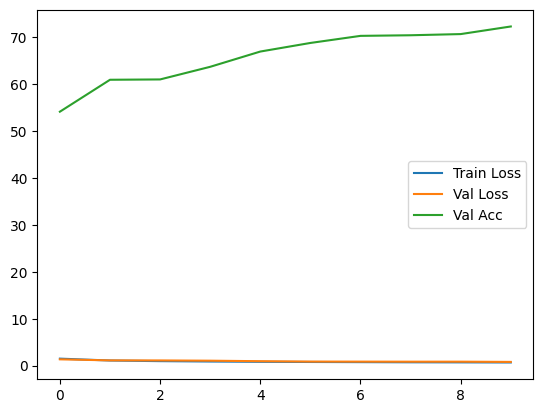

In [10]:
# 绘制训练曲线
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.plot(metrics['val_acc'], label='Val Acc')
plt.legend()
plt.show()

## 1-3 模型保存

为了方便后面剪枝的进行，需要自定义模型保存方式

In [14]:
def generate_prune_mask(model):
    """生成各层的剪枝掩码（示例：随机剪枝50%）"""
    masks = {}
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            out_channels = layer.out_channels
            # 生成随机掩码（实际应替换为GA的剪枝决策）
            masks[name] = torch.rand(out_channels) > 0.5  
    return masks

# 自定义结构保存格式
def save_pruned_model(model, mask_dict, name='pruned_model.pth'):
    """ mask_dict: 记录各层保留通道的布尔掩码 """
    torch.save({
        'state_dict': model.state_dict(),
        'model_arch': model.get_pruned_config(),  # 需自定义方法
        'mask': mask_dict
    }, 'pruned_model.pth')

def load_pruned_model(path):
    checkpoint = torch.load(path)
    model = SimpleCNN()  # 原始结构
    
    # 应用剪枝
    pruned_model = prune_model(
        model, 
        masks=checkpoint['mask'],
        config=checkpoint['model_arch']
    )
    pruned_model.load_state_dict(checkpoint['state_dict'])
    return pruned_model

In [15]:
mask = generate_prune_mask(model)  # 实际应由遗传算法生成
save_pruned_model(model, mask, 'ga_pruned_model.pth')

# 2 基于DEAP配置遗传算法
## 2-1 配置个体和种群

In [1]:
def configure_ga_toolbox(model, seed=42):
    """
    配置遗传算法工具箱
    :param model: 目标CNN模型实例（需继承nn.Module）
    :param seed: 随机种子（默认42）
    :return: 配置完成的DEAP toolbox对象
    """
    # ===== 动态计算染色体长度 =====
    def get_chromosome_length():
        return sum(layer.out_channels for layer in model.modules() 
                 if isinstance(layer, torch.nn.Conv2d))
    # ===== 基因有效性校验 =====
    def validate_gene(indiv):
        ptr = 0
        for layer in model.modules():
            if isinstance(layer, torch.nn.Conv2d):
                genes = indiv[ptr : ptr+layer.out_channels]
                if sum(genes) == 0:  # 通道全0保护
                    indiv[ptr + random.randint(0, layer.out_channels-1)] = 1
                ptr += layer.out_channels
        return indiv
      
    # 设置随机种子
    random.seed(seed)
    torch.manual_seed(seed)
    # 计算gene长度
    n = get_chromosome_length()
    
    # ===== 创建遗传算法组件 =====
    # 防止重复创建报错
    if "FitnessMax" in creator.__dict__:
        del creator.FitnessMax
    if "Individual" in creator.__dict__:
        del creator.Individual

    # 定义适应度类型: FitnessMax表示最大化单目标
    # weights指定优化方向：正值表示最大化，负值最小化。weights=(1.0,)表示单目标优化的权重。如果是weights=(1.0, -1.0)，那就是双目标优化
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    # 定义个体类型：列表存储基因序列 + 附加适应度属性
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    """
    注册个体生成方法
    个体类型：creator.Individual
    生成器：tools.initIterate | 通过迭代器构造对象 | 适用于需要复杂初始化逻辑的场景
    生成器：tools.initRepeat | 重复调用构造函数生成集合 | 适用于批量生成相同结构的对象
    lambda函数：生成经过验证的基因序列，再包装成creator.Individual的实例
    """
    toolbox.register("individual", tools.initIterate, creator.Individual,
                   lambda: validate_gene(
                       [torch.randint(0,2,(1,)).item() for _ in range(n)]
                   )) # 使用PyTorch的randint替代Python原生随机
    # 注册种群生成方法
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    return toolbox

In [18]:
toolbox = configure_ga_toolbox(model, seed=42)

# 生成测试种群
population = toolbox.population(n=50)  # 生成50个个体的种群
print(f"种群大小: {len(population)}, 染色体长度: {len(population[0])}")

种群大小: 50, 染色体长度: 224


## 2-2 配置选择-交叉-变异

In [ ]:
# 将 evaluate()适应度函数注册到 toolbox，这样 Deap 在进化时会自动调用 evaluate() 评估个体适应度。
toolbox.register("evaluate", evaluate)

# 添加CUDA并行评估
import torch.multiprocessing as mp  # 使用 PyTorch 兼容的多进程库
pool = mp.Pool(processes=min(torch.cuda.device_count(), 4))  # 限制最大并行进程数
toolbox.register("map", pool.map)

# 交叉-变异-选择
toolbox.register("mate", tools.cxUniform, indpb=0.5)  # 均匀交叉
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)  # 0.1的变异概率
toolbox.register("select", tools.selBest, k=5)  # 只保留最优个体，加快收敛速度

## 3：定义剪枝和评估函数
这一部分的任务是加载预训练模型并定义剪枝逻辑及适应度评估。  
修改了以下几个地方：
1. clone()之前先.to(device)，可以减少不必要的 GPU 计算图拷贝
2. 自动适配 device，确保 original_model 和 pruned_model 在同一设备

In [28]:
def prune_model(original_model, conv1_indices, conv2_indices):
    """基于剪枝索引创建新的CNN模型，并高效转移权重"""
    
    # 自动获取原始模型所在设备
    device = original_model.conv1.weight.device  

    # 如果 conv1_indices 为空，则返回 None 并释放显存
    if not conv1_indices or len(conv1_indices) == 0:
        torch.cuda.empty_cache()  # 释放显存
        return None
    
    # 创建剪枝后的模型，放在相同的设备上
    pruned_model = SimpleCNN().to(device)
    
    # 剪枝 Conv1（确保索引合法）
    pruned_model.conv1.weight.data = original_model.conv1.weight.data[conv1_indices].to(device).clone()
    pruned_model.conv1.bias.data = original_model.conv1.bias.data[conv1_indices].to(device).clone()

    # 如果 conv2_indices 为空，则返回 None 并释放显存
    if not conv2_indices or len(conv2_indices) == 0:
        del pruned_model
        torch.cuda.empty_cache()
        return None

    # 剪枝 Conv2，确保权重索引正确（同时剪枝输入通道和输出通道）
    pruned_model.conv2.weight.data = (
        original_model.conv2.weight.data[conv2_indices][:, conv1_indices, :, :].to(device).clone()
    )
    pruned_model.conv2.bias.data = original_model.conv2.bias.data[conv2_indices].to(device).clone()

    # 剪枝 Conv3（仅修改输入通道，不剪枝输出通道）
    pruned_model.conv3.weight.data = original_model.conv3.weight.data[:, :len(conv2_indices), :, :].to(device).clone()
    pruned_model.conv3.bias.data = original_model.conv3.bias.data.to(device).clone()

    # 复制全连接层权重（FC 层通常不剪枝）
    pruned_model.fc.weight.data = original_model.fc.weight.data.to(device).clone()
    pruned_model.fc.bias.data = original_model.fc.bias.data.to(device).clone()

    return pruned_model  # 返回剪枝后的新模型

优化：
1. 显式调用 gc.collect() 清理 Python 对象引用
2. 使用 with torch.no_grad() 加速推理

In [29]:
# 是否启用 debug 输出
DEBUG = False  

def evaluate(individual):
    """评估剪枝后模型的适应度（基于准确率）"""
    
    if DEBUG:
        print("Evaluating individual:", individual)

    # 解码染色体（获得要保留的卷积核索引）
    conv1_indices = [i for i, bit in enumerate(individual[:64]) if bit == 1]
    conv2_indices = [i for i, bit in enumerate(individual[64:192]) if bit == 1]
    
    # 约束：如果某层没有保留任何卷积核，则适应度设为 0
    if not conv1_indices or not conv2_indices:
        torch.cuda.empty_cache()  # 仅在需要时释放显存
        return (0,)

    # 加载预训练模型到 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    original_model = SimpleCNN().to(device)
    original_model.load_state_dict(torch.load('pretrained_model.pth', map_location=device))

    try:
        # 剪枝模型
        pruned_model = prune_model(original_model, conv1_indices, conv2_indices)
        if pruned_model is None:
            torch.cuda.empty_cache()
            return (0,)

        # 评估剪枝后模型的准确率（加速推理）
        with torch.no_grad():
            accuracy = test_accuracy(pruned_model)

        # 显存清理（确保显式释放）
        del original_model, pruned_model
        gc.collect()  # 释放 Python 对象
        torch.cuda.empty_cache()  # 释放 GPU 缓存

        return (accuracy,)

    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print(f"显存溢出: {str(e)}")
            torch.cuda.empty_cache()
            return (0,)
        else:
            raise e  # 抛出其他异常，避免静默失败

优化：
1. 使用CPU的4核来优化数据加载
2. 增加AMP自动混合精度：用torch.autocast()启用FP16

In [30]:
def test_accuracy(model):
    """评估模型在测试集上的准确率"""
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # 只在数据未下载时下载，避免重复检查
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

    # 优化数据加载：使用并行加载和固定内存
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True
    )

    # 确保 `model` 和 `inputs` 在相同设备上
    device = next(model.parameters()).device
    if next(model.parameters()).device != device:
        model.to(device)
    
    model.eval()
    
    correct = 0
    total = 0
    
    # 启用 AMP 进行 FP16 推理，提高计算速度
    with torch.no_grad(), torch.autocast(device_type="cuda", dtype=torch.float16):
        for inputs, labels in testloader:
            # 异步传输数据到 GPU
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total  # 返回准确率

优化：
1. 这里我限制了最大进程数为4，避免开太多进程导致 CUDA 争用（除非你有 4 块 GPU）。通常 4 个并行进程足够充分调用1 张 GPU。
2. 在选择策略中只保留最有个体，尽可能加快收敛速度

## 4：运行遗传算法剪枝
优化：
1. 使用 starmap 并行计算（避免 map 在某些平台上性能下降）。或使用 `executor.map()`并行计算适应度（轻量级线程池）
2. 使用 torch.jit.script 编译 evaluate()，加速适应度计算
3. 减少 NGEN（遗传代数）但增加 population（种群规模），让GPU更忙。

In [32]:
def run_genetic_algorithm(population_size=100, ngen=10, cxpb=0.7, mutpb=0.1):
    """
    执行遗传算法优化 CNN 剪枝
    :param population_size: 种群大小
    :param ngen: 遗传代数
    :param cxpb: 交叉概率
    :param mutpb: 变异概率
    :return: 最佳个体
    """

    print(f"运行遗传算法: 交叉率 {cxpb}, 变异率 {mutpb}, 代数 {ngen}, 种群规模 {population_size}")
    
    # **初始化种群**
    population = toolbox.population(n=population_size)

    try:
        with ThreadPoolExecutor(max_workers=4) as executor:
            for gen in range(ngen):
                print(f"Generation {gen+1}/{ngen} 开始")

                # **交叉 & 变异**
                offspring = algorithms.varAnd(population, toolbox, cxpb, mutpb)

                # **并行计算适应度**
                fits = list(executor.map(toolbox.evaluate, offspring))
                for fit, ind in zip(fits, offspring):
                    ind.fitness.values = fit

                # **精英保留策略**
                elite = tools.selBest(population, k=2)
                offspring = toolbox.select(offspring, k=len(population) - len(elite))
                population = elite + offspring

                print(f"Generation {gen+1}/{ngen} 结束\n")

        # **返回最佳个体**
        best_ind = tools.selBest(population, k=1)[0]
        return best_ind

    finally:
        pool.close()
        pool.join()
        print("遗传算法完成，释放资源")

In [1]:
def main():
    """主函数，调用遗传算法，并保存最佳剪枝方案和模型"""
    start_time = time.time()  # 记录开始时间
    
    # 运行遗传算法
    best_ind = run_genetic_algorithm(population_size=20, ngen=1, cxpb=0.5, mutpb=0.05)

    # 保存最佳个体
    with open("best_individual.pkl", "wb") as f:
        pickle.dump(best_ind, f)
    print(f"已保存最佳剪枝方案: best_individual.pkl")

    # 剪枝 CNN 并保存模型
    original_model = SimpleCNN().to(device)
    original_model.load_state_dict(torch.load('pretrained_model.pth', map_location=device))

    # 解码 `best_ind` 并应用剪枝
    conv1_indices = [i for i, bit in enumerate(best_ind[:64]) if bit == 1]
    conv2_indices = [i for i, bit in enumerate(best_ind[64:192]) if bit == 1]
    pruned_model = prune_model(original_model, conv1_indices, conv2_indices)

    # 保存剪枝后的模型
    if pruned_model:
        torch.save(pruned_model.state_dict(), "pruned_model.pth")
        print(f"剪枝后模型已保存: pruned_model.pth")
    else:
        print("剪枝后模型无效（可能所有通道都被剪枝），未保存！")

    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time
    print(f"训练完成！总耗时：{elapsed_time:.2f} 秒")  # 显示训练时间

In [34]:
if __name__ == "__main__":
    torch.backends.cudnn.benchmark = True  # 启用 cuDNN 自动优化
    main()

运行遗传算法: 交叉率 0.7, 变异率 0.1, 代数 1, 种群规模 20
Generation 1/1 开始
遗传算法完成，释放资源


KeyboardInterrupt: 

In [19]:
# 终止进程池（如果还在运行）
try:
    pool.terminate()
    pool.join()
    print("已成功关闭 multiprocessing 进程池")
except:
    print("未找到正在运行的 multiprocessing 进程")

# 清理 CUDA 缓存
torch.cuda.empty_cache()
print("CUDA 显存缓存已清理")

已成功关闭 multiprocessing 进程池
CUDA 显存缓存已清理


## 5：微调剪枝后的模型

剪枝后的模型要使用微调，而不是重新训练。如果重新训练的话，那剪枝不就没有意义了吗？
对找到的最佳剪枝模型进行微调以恢复性能。

In [21]:
def fine_tune(pruned_model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pruned_model.to(device)  # 确保模型在GPU
    optimizer = optim.SGD(pruned_model.parameters(), lr=0.0001)
    
    # 使用混合精度训练
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(5):
        pruned_model.train()
        for inputs, labels in trainloader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # 自动混合精度
                outputs = pruned_model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
    return pruned_model

# 6：测试性能

In [25]:
def evaluate_model(model, model_name="Model"):
    """
    评估 CNN 模型（剪枝前/剪枝后）：
    1. 计算在 CIFAR-10 测试集上的准确率
    2. 统计 FLOPs（计算量）和参数量
    """
    # **确保模型在 GPU 上**
    model.to(device)
    model.eval()

    # **测试集预处理**
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # **加载 CIFAR-10 测试集**
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=8, pin_memory=True)

    # **推理加速**
    correct = 0
    total = 0
    start_time = time.time()  # 计时
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # **启用 FP16 计算加速**
            with torch.cuda.amp.autocast():
                outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # **计算准确率**
    accuracy = 100 * correct / total
    end_time = time.time()

    print(f"\n{model_name} 评估结果:")
    print(f"{model_name} 准确率: {accuracy:.2f}%")
    print(f"推理时间: {end_time - start_time:.4f} 秒")

    # **统计模型的 FLOPs & 参数量**
    print("\n模型统计信息:")
    summary(model, input_size=(1, 3, 32, 32), device=device)

    return accuracy


In [26]:
def compare_models():
    """对比未剪枝模型和剪枝模型的性能"""

    # **加载未剪枝模型**
    original_model = SimpleCNN().to(device)
    original_model.load_state_dict(torch.load("pretrained_model.pth", map_location=device))
    
    # **加载剪枝后的模型**
    pruned_model = SimpleCNN().to(device)
    pruned_model.load_state_dict(torch.load("pruned_model.pth", map_location=device))

    # **评估二者性能**
    acc_original = evaluate_model(original_model, "未剪枝模型")
    acc_pruned = evaluate_model(pruned_model, "剪枝后模型")

    # **性能对比**
    print("\n**剪枝前后模型性能对比**")
    print(f"未剪枝模型准确率: {acc_original:.2f}%")
    print(f"剪枝后模型准确率: {acc_pruned:.2f}%")
    print(f"剪枝后模型的准确率下降: {acc_original - acc_pruned:.2f}%**")


In [ ]:
torch.backends.cudnn.benchmark = True  # 启用 cuDNN 自动优化
compare_models()